# Experiments

In [ ]:
import os
import IPython.display as ipd

for filename in os.listdir('./test'):
    ipd.Audio('./test/' + filename)

In [ ]:
import os
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

for filename in os.listdir('./test'):
    data, sampling_rate = librosa.load('./test/' + filename)

    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
import speech_recognition as sr

In [ ]:
r = sr.Recognizer()

In [ ]:
zero = sr.AudioFile('0_jackson_2.wav')

In [ ]:
with zero as source:
    audio = r.record(source)

In [ ]:
print(r.recognize_google(audio))

# This is the main training part:

## training with audio files

In [12]:
%load_ext autoreload
%autoreload 2

from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 50
batch_size = 100
verbose = 1
# change num_classes depending on the amount of labels
num_classes = 12

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Saving vectors of label - '9': 100%|█████████████████████████████████████████████████| 139/139 [00:02<00:00, 63.27it/s]


## model & prediction

In [14]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [30]:
model = get_model()
history = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 1283 samples, validate on 856 samples
Epoch 1/50
1283/1283 [==============================] - ETA: 9s - loss: 6.2572 - acc: 0.050 - ETA: 4s - loss: 5.5132 - acc: 0.065 - ETA: 3s - loss: 4.9025 - acc: 0.076 - ETA: 2s - loss: 4.3949 - acc: 0.085 - ETA: 1s - loss: 4.1168 - acc: 0.088 - ETA: 1s - loss: 3.8588 - acc: 0.090 - ETA: 1s - loss: 3.6543 - acc: 0.100 - ETA: 0s - loss: 3.4811 - acc: 0.115 - ETA: 0s - loss: 3.3534 - acc: 0.126 - ETA: 0s - loss: 3.2442 - acc: 0.135 - ETA: 0s - loss: 3.1429 - acc: 0.147 - ETA: 0s - loss: 3.0571 - acc: 0.158 - 2s 2ms/step - loss: 2.9957 - acc: 0.1652 - val_loss: 1.7742 - val_acc: 0.6262
Epoch 2/50
1283/1283 [==============================] - ETA: 1s - loss: 2.0448 - acc: 0.370 - ETA: 1s - loss: 2.0072 - acc: 0.355 - ETA: 0s - loss: 1.9753 - acc: 0.356 - ETA: 0s - loss: 1.9542 - acc: 0.350 - ETA: 0s - loss: 1.9687 - acc: 0.340 - ETA: 0s - loss: 1.9237 - acc: 0.345 - ETA: 0s - loss: 1.8787 - acc: 0.357 - ETA: 0s - loss: 1.8348 - acc: 0.373 - ETA

1283/1283 [==============================] - ETA: 1s - loss: 0.2474 - acc: 0.930 - ETA: 1s - loss: 0.2513 - acc: 0.920 - ETA: 0s - loss: 0.2231 - acc: 0.923 - ETA: 0s - loss: 0.2347 - acc: 0.917 - ETA: 0s - loss: 0.2528 - acc: 0.912 - ETA: 0s - loss: 0.2548 - acc: 0.910 - ETA: 0s - loss: 0.2581 - acc: 0.910 - ETA: 0s - loss: 0.2680 - acc: 0.907 - ETA: 0s - loss: 0.2759 - acc: 0.904 - ETA: 0s - loss: 0.2872 - acc: 0.898 - ETA: 0s - loss: 0.2863 - acc: 0.899 - ETA: 0s - loss: 0.2895 - acc: 0.899 - 2s 1ms/step - loss: 0.2842 - acc: 0.9010 - val_loss: 0.2525 - val_acc: 0.9124
Epoch 15/50
1283/1283 [==============================] - ETA: 1s - loss: 0.2068 - acc: 0.920 - ETA: 1s - loss: 0.2647 - acc: 0.900 - ETA: 0s - loss: 0.2273 - acc: 0.923 - ETA: 0s - loss: 0.2021 - acc: 0.937 - ETA: 0s - loss: 0.2022 - acc: 0.934 - ETA: 0s - loss: 0.2014 - acc: 0.931 - ETA: 0s - loss: 0.2184 - acc: 0.924 - ETA: 0s - loss: 0.2307 - acc: 0.917 - ETA: 0s - loss: 0.2459 - acc: 0.914 - ETA: 0s - loss: 0.2473

Epoch 28/50
1283/1283 [==============================] - ETA: 1s - loss: 0.2270 - acc: 0.920 - ETA: 1s - loss: 0.1888 - acc: 0.925 - ETA: 0s - loss: 0.1832 - acc: 0.933 - ETA: 0s - loss: 0.1863 - acc: 0.927 - ETA: 0s - loss: 0.1665 - acc: 0.936 - ETA: 0s - loss: 0.1648 - acc: 0.935 - ETA: 0s - loss: 0.1579 - acc: 0.938 - ETA: 0s - loss: 0.1622 - acc: 0.936 - ETA: 0s - loss: 0.1539 - acc: 0.937 - ETA: 0s - loss: 0.1503 - acc: 0.939 - ETA: 0s - loss: 0.1485 - acc: 0.939 - ETA: 0s - loss: 0.1468 - acc: 0.939 - 1s 1ms/step - loss: 0.1461 - acc: 0.9415 - val_loss: 0.2804 - val_acc: 0.8960
Epoch 29/50
1283/1283 [==============================] - ETA: 1s - loss: 0.2329 - acc: 0.910 - ETA: 1s - loss: 0.1620 - acc: 0.940 - ETA: 0s - loss: 0.1337 - acc: 0.956 - ETA: 0s - loss: 0.1347 - acc: 0.955 - ETA: 0s - loss: 0.1274 - acc: 0.960 - ETA: 0s - loss: 0.1414 - acc: 0.955 - ETA: 0s - loss: 0.1356 - acc: 0.955 - ETA: 0s - loss: 0.1257 - acc: 0.960 - ETA: 0s - loss: 0.1230 - acc: 0.961 - ETA: 0s - 

1283/1283 [==============================] - ETA: 1s - loss: 0.0345 - acc: 0.990 - ETA: 0s - loss: 0.0293 - acc: 0.990 - ETA: 0s - loss: 0.0459 - acc: 0.980 - ETA: 0s - loss: 0.0572 - acc: 0.975 - ETA: 0s - loss: 0.0713 - acc: 0.972 - ETA: 0s - loss: 0.0780 - acc: 0.970 - ETA: 0s - loss: 0.0784 - acc: 0.971 - ETA: 0s - loss: 0.0752 - acc: 0.972 - ETA: 0s - loss: 0.0834 - acc: 0.971 - ETA: 0s - loss: 0.0887 - acc: 0.970 - ETA: 0s - loss: 0.0829 - acc: 0.971 - ETA: 0s - loss: 0.0845 - acc: 0.971 - 2s 1ms/step - loss: 0.0809 - acc: 0.9735 - val_loss: 0.3374 - val_acc: 0.9077
Epoch 42/50
1283/1283 [==============================] - ETA: 1s - loss: 0.0698 - acc: 0.970 - ETA: 0s - loss: 0.0411 - acc: 0.985 - ETA: 0s - loss: 0.0468 - acc: 0.983 - ETA: 0s - loss: 0.0545 - acc: 0.982 - ETA: 0s - loss: 0.0622 - acc: 0.982 - ETA: 0s - loss: 0.0716 - acc: 0.976 - ETA: 0s - loss: 0.0675 - acc: 0.977 - ETA: 0s - loss: 0.0710 - acc: 0.975 - ETA: 0s - loss: 0.0683 - acc: 0.975 - ETA: 0s - loss: 0.0652

## Predict on a new file:

In [27]:
print(predict('./test_audio/12.wav', model=model))

2


## Accuracy single

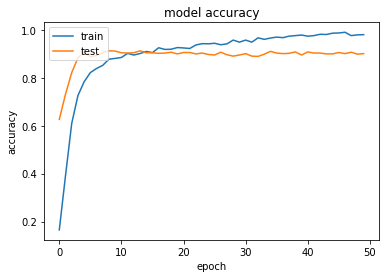

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss single

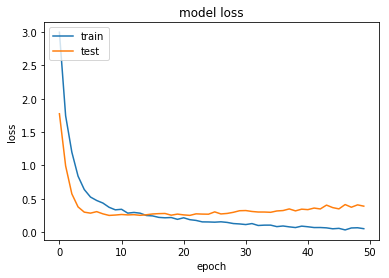

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Full report with confusion matrix

Accuracy : 0.9007009345794392

Classification Report
              precision    recall  f1-score   support

           0    0.80537   0.97561   0.88235       123
           1    0.90164   0.87302   0.88710        63
           2    0.93333   0.91803   0.92562        61
           3    0.82759   0.94118   0.88073        51
           4    0.88235   0.78947   0.83333        95
           5    0.96053   0.72277   0.82486       101
           6    1.00000   0.87755   0.93478        49
           7    0.92857   0.95588   0.94203        68
           8    0.84722   1.00000   0.91729        61
           9    0.95000   0.87692   0.91200        65
          10    1.00000   1.00000   1.00000        66
          11    0.92857   0.98113   0.95413        53

   micro avg    0.90070   0.90070   0.90070       856
   macro avg    0.91376   0.90930   0.90785       856
weighted avg    0.90728   0.90070   0.89946       856

[[120   0   1   0   2   0   0   0   0   0   0   0]
 [  0  55   1   3   0   0   0

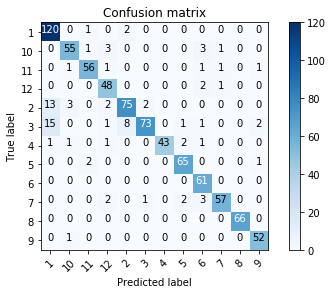

In [56]:
labels = np.array(['1','2','3','4','5','6','7','8','9','10','11','12'])

le = LabelEncoder()

le.fit_transform(labels)

full_multiclass_report(model, X_test, y_test_hot, classes=le.inverse_transform(np.arange(12)))

## Loss and accuracy plot

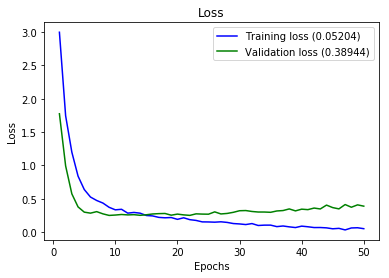

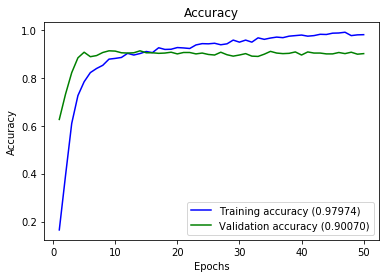

In [43]:
plot_history(history)

# Functions for all the metrics and results

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [42]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()